In [1]:
import os
import numpy as np
import mne
import osl
import yaml
import pickle
from scipy.io import savemat
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# import loadmat
from scipy.io import loadmat

# import classifiers_linear from parent dir
import sys
sys.path.append('../')
import classifiers_linear

# import distance_riemann
from pyriemann.utils.distance import distance_riemann

In [2]:
# load data
chn = list(range(54))
x_train_ts = []
x_val_ts = []
x_test_ts = []

path = os.path.join('/', 'well', 'woolrich', 'projects',
                                 'disp_csaky', 'eeg',
                                 'preproc1_40hz_noica', 'inner_speech_long',
                                 'standard_scaler_norandom100sr0', 'c')

# load data for each channel
for index, i in enumerate(chn):
    data = loadmat(path + 'ch' + str(i) + '.mat')
    x_train_ts.append(np.array(data['x_train_t']))

    if index == 0:
        sub_id = np.array(data['sub_id_train'])

x_train = np.concatenate(tuple(x_train_ts), axis=1)

In [3]:
# load model
path = os.path.join('..',
            'results',
            'disp_epoched',
            'eeg',
            '9sessions_noica',
            'standard_cov_longepochs',
            'model.pt100')
model = pickle.load(open(path, 'rb'))

weights = model.model.coef_

In [4]:
x_train = x_train[:, :-1, :]

In [5]:
# remove mean over 3rd dimension in x_train
x_train = x_train - np.mean(x_train, axis=2, keepdims=True)

In [10]:
T

201

In [11]:
C = x_train.shape[1]
T = x_train.shape[2]
num_trials = x_train.shape[0]

x_train_flat = x_train.reshape(num_trials, -1)

patterns = np.empty((num_trials, C * T, 5), dtype=x_train.dtype)
for t in range(10):
    x = x_train_flat[t]

    w = np.zeros((C * T, C * (C // 2 + 1)))

    for i in range(C):
        vals = x[i * T:(i + 1) * T]
        w[i * T:(i + 1) * T, i * (i + 1) // 2:(i + 1) * (i + 2) // 2] = vals[:, None] / (T - 1)

    combined_weight = np.dot(w, weights.T)
    y = np.dot(x, combined_weight)

    x_cov = np.outer(x, x)
    y_cov = np.outer(y, y)

    patterns[t, :, :] = np.einsum('ij,jk,kl->il', x_cov, combined_weight, np.linalg.inv(y_cov))

In [67]:
x_trans = x_flat @ w
x_trans[:10]

In [27]:
mat = np.triu(np.cov(x)).reshape(-1)
mat = mat[mat != 0]
mat[:10]

array([0.23693655, 0.45169227, 0.4280469 , 0.39324306, 0.38239824,
       0.20841964, 0.21024948, 0.30384162, 0.45416859, 0.5288225 ])

In [13]:
# decompose weights into patterns according to Haufe transformation
# i can get a pattern matrix for each trial, but not for the whole dataset
# because the weight matrix is different for each trial

# look at the trial-wise patterns and at the average pattern over trials
patterns = patterns[:10].reshape(10, 53, 201, 5)

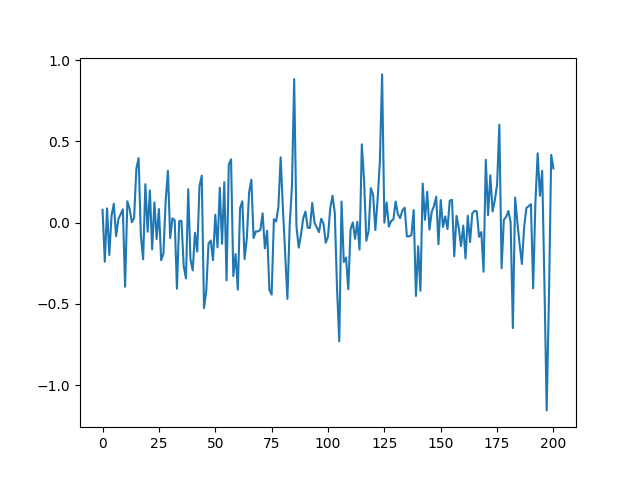

In [17]:
%matplotlib widget
plt.plot(np.mean(patterns, axis=(0, 3))[17, :])